# Lending Tree Loan Status: SMOTE
## Classification: XGBoost GPU
### Hyperopt HPO: 100 Trials 3-fold Cross Validation

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install eli5
import os
import random
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold 
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
from datetime import datetime, timedelta
import time
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 
from eli5.sklearn import PermutationImportance 
import webbrowser
from eli5.formatters import format_as_dataframe
warnings.filterwarnings('ignore')
my_dpi = 96
print('\n')
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 15.0 MB/s 
     |████████████████████████████████| 133 kB 80.7 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=46449740a40373a9456203e27077fac63cbd3566c998024a326b43a52907656a
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incomp

In [ ]:
# Set seed 
seed_value = 42
os.environ['LoanStatus_xgbGPU_SMOTE'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = pd.read_csv('trainDF_SMOTE.csv', low_memory=False)
testDF = pd.read_csv('testDF_SMOTE.csv', low_memory=False)

In [ ]:
# Set up train/test split
X1_train = trainDF.drop('loan_status', axis=1)
y1_train = trainDF.loan_status
X1_test = testDF.drop('loan_status', axis=1)
y1_test = testDF.loan_status

### 100 Trials 3-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=3, shuffle=True, random_state=seed_value)

# Define parameter grid
xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):

    """Objective function to tune a `XGBoostClassifier` model."""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        tree_method='gpu_hist',
                        scale_pos_weight=1,
                        use_label_encoder=False,
                        random_state=seed_value,
                        verbosity=0,
                        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X1_train, y1_train, 
                              scoring='roc_auc', cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    best_score = np.max(scores)
    
    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, config, ITERATION, run_time])
    
    return {'loss': loss, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'XGBoost_HPO_SMOTE_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_SMOTE_trials = Trials()

In [ ]:
# Start timer for experiment
search_time_start = time.time()
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_SMOTE_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
print('Time to run HPO:', time.time() - search_time_start)

100%|██████████| 100/100 [1:46:05<00:00, 63.65s/it, best loss: 1.9823955866295848]
Time to run HPO: 6365.12714266777


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_SMOTE_trials_results = sorted(bayesOpt_SMOTE_trials.results, 
                                       key=lambda x: x['loss'])
print('SMOTE HPO 100 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_SMOTE_trials_results[:2])

SMOTE HPO 100 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9823955866295848, 'params': {'colsample_bylevel': 0.058634405251831605, 'colsample_bytree': 0.5068689191757614, 'gamma': 7.391202360090186, 'learning_rate': 0.0010284233210005843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 309, 'reg_alpha': 26, 'reg_lambda': 1.7709301629879193, 'subsample': 0.30873146426206194}, 'iteration': 22, 'train_time': 57.581713156000205, 'status': 'ok'}, {'loss': 1.9896220822185486, 'params': {'colsample_bylevel': 0.10129290953922618, 'colsample_bytree': 0.5466585360117832, 'gamma': 7.259042843754013, 'learning_rate': 0.0010337194642798808, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 309, 'reg_alpha': 18, 'reg_lambda': 0.6026190751579736, 'subsample': 0.3584614673395253}, 'iteration': 30, 'train_time': 69.02985279099994, 'status': 'ok'}]


In [ ]:
# Read results from csv
results = pd.read_csv('XGBoost_HPO_SMOTE_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_SMOTE_model = XGBClassifier(objective='binary:logistic', 
                                       booster='gbtree', 
                                       tree_method='gpu_hist',
                                       scale_pos_weight=1, 
                                       use_label_encoder=False, 
                                       random_state=seed_value,
                                       verbosity=0,
                                       **best_bayes_params)

# Fit the model
best_bayes_SMOTE_model.fit(X1_train, y1_train)

# Save model
Pkl_Filename = 'XGB_SMOTE_HPO_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_SMOTE_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_SMOTE_HPO_100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO 100 trials GPU')
# Predict based on training 
y_train_pred = best_bayes_SMOTE_model.predict(X1_train)
y_test_pred = best_bayes_SMOTE_model.predict(X1_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y1_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y1_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y1_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y1_test, y_test_pred))
print('Recall score : %.3f' % recall_score(y1_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y1_test, y_test_pred))


Model Metrics for XGBoost HPO 100 trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96    377848
           1       0.76      0.58      0.66     54625

    accuracy                           0.92    432473
   macro avg       0.85      0.78      0.81    432473
weighted avg       0.92      0.92      0.92    432473



Confusion matrix:
[[367783  10065]
 [ 23014  31611]]


Accuracy score : 0.924
Precision score : 0.758
Recall score : 0.579
F1 score : 0.657


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_SMOTE_model.predict_proba(X1_test)[:, 1]
print('The best model from SMOTE Bayes optimization 100 trials scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y1_test, 
                                                                                                                            preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from SMOTE Bayes optimization 100 trials scores 0.90219 AUC ROC on the test set.
This was achieved after 22 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_SMOTE_100_GPU.csv', index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

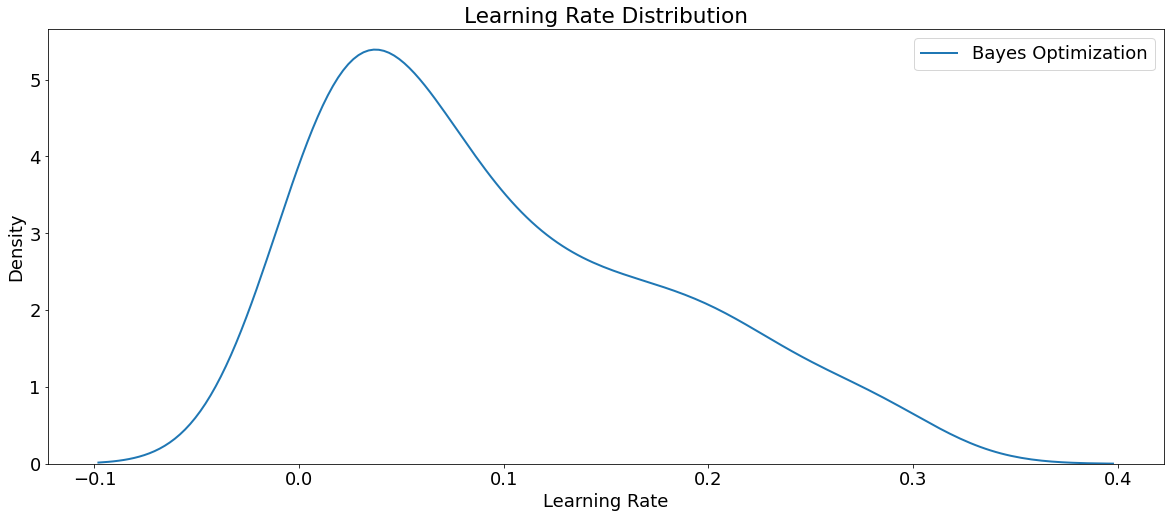

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

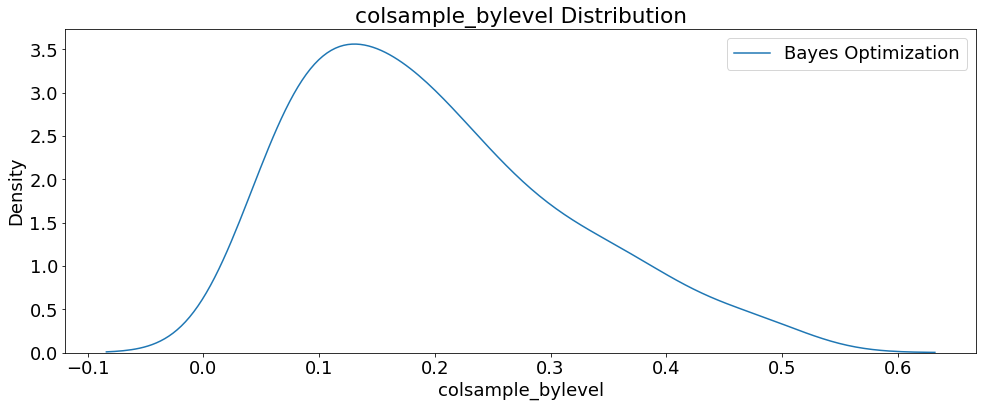

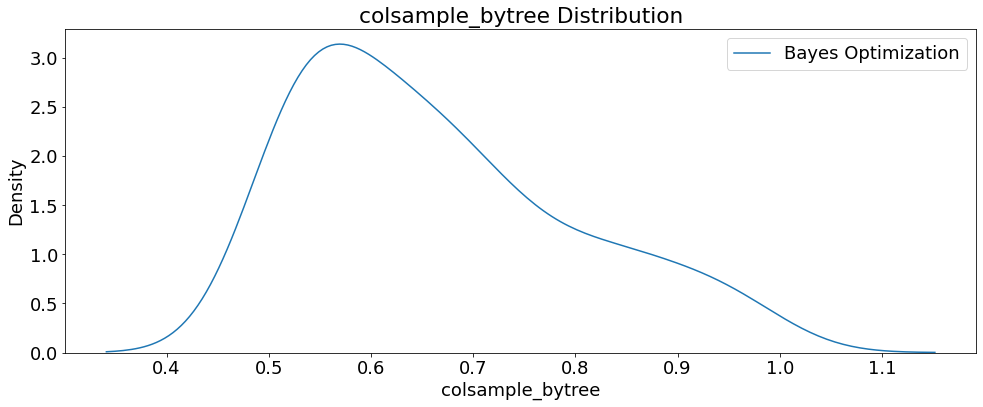

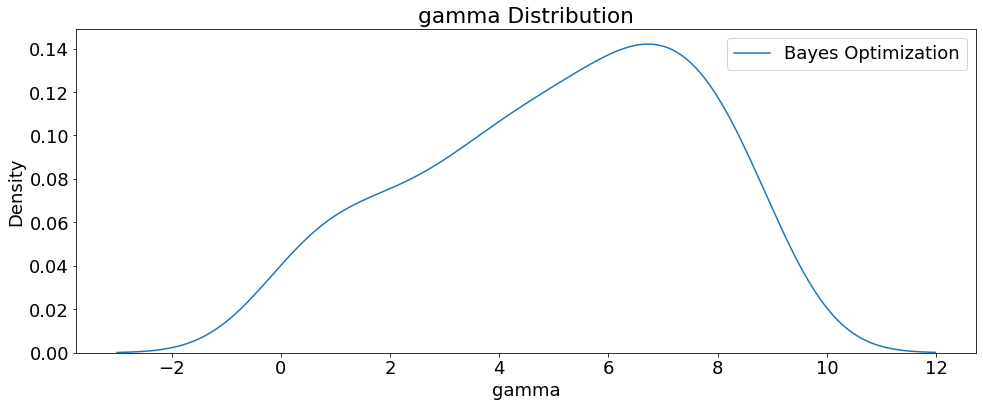

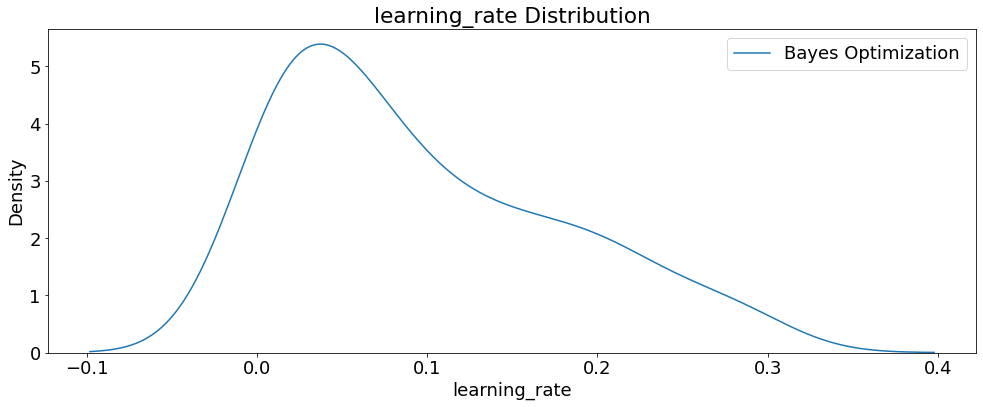

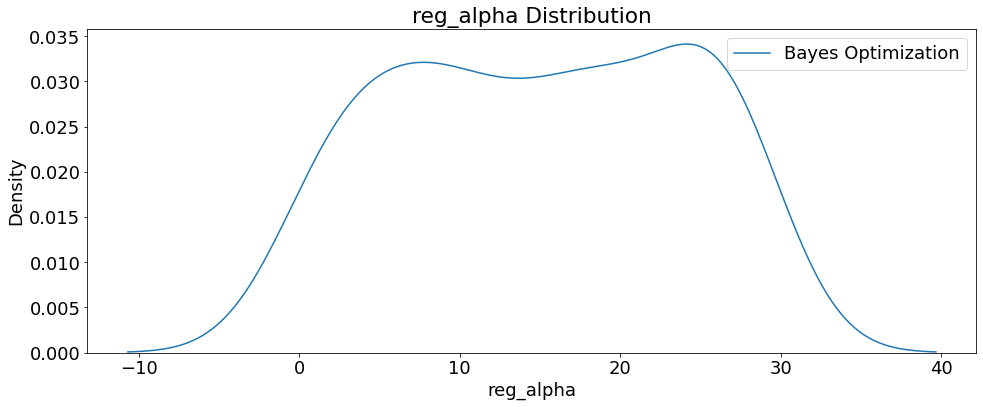

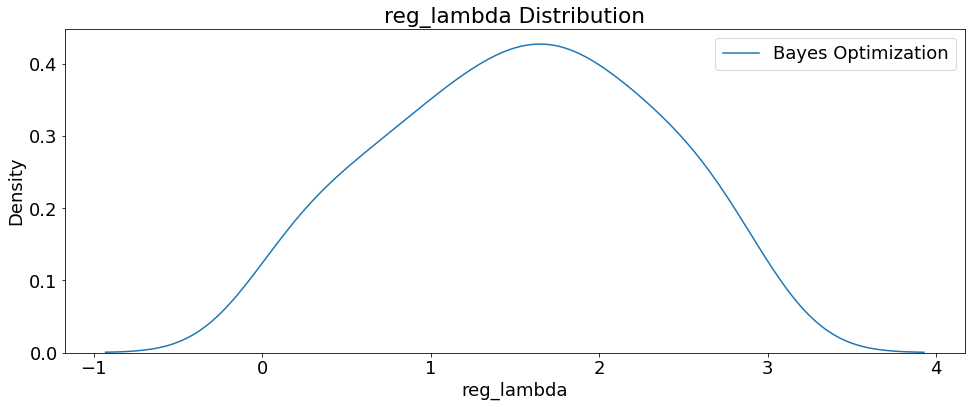

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

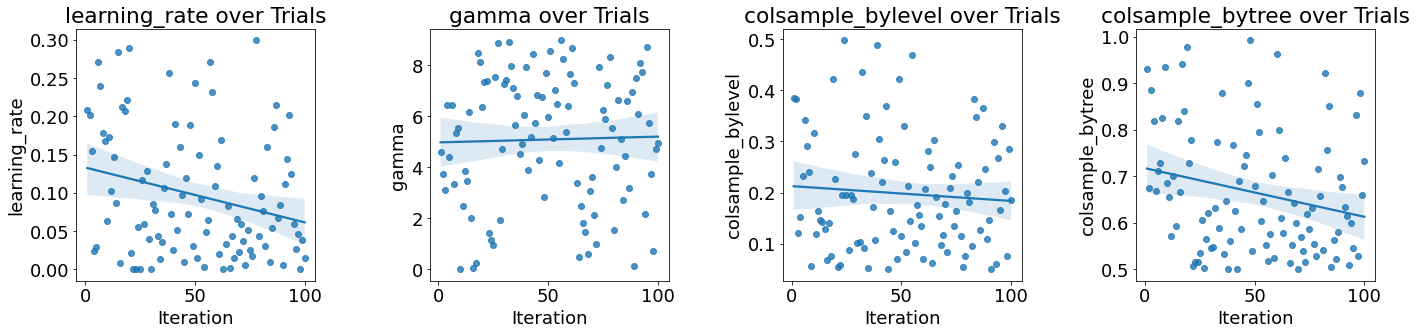

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

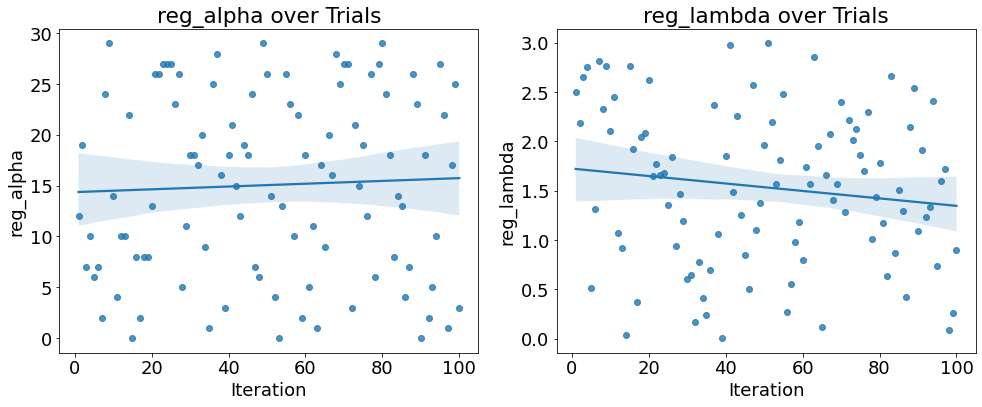

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations


In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_SMOTE_model,
                                        random_state=seed_value).fit(X1_test,
                                                                     y1_test)

X1_test1 = pd.DataFrame(X1_test, columns=X1_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X1_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_SMOTE_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_SMOTE_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0487 ± 0.0007,recoveries
0.0212 ± 0.0005,last_pymnt_amnt
0.0172 ± 0.0003,out_prncp
0.0065 ± 0.0002,total_pymnt
0.0025 ± 0.0002,total_rec_late_fee
0.0017 ± 0.0003,term_ 60 months
0.0015 ± 0.0001,loan_amnt
0.0010 ± 0.0002,installment
0.0009 ± 0.0000,verification_status_Source Verified
0.0005 ± 0.0001,verification_status_Verified


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance, 
                                           feature_names=X1_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_SMOTE_100_GPU_WeightsExplain.csv', index=False)
exp